<a href="https://colab.research.google.com/github/adricarda/15Puzzle/blob/master/hands_on_22_23/04_metric_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **🎅 Machine Learning For Computer Vision**
# **🎄 Hands-on sessions 🎄**

# Session 4: Metric Learning.

In this session, we will learn how to:

- Build a Face Identification pipeline.
- Write a Triplet Dataset.
- Experiment with Image Retrieval.
- Write a custom loss function.

Prerequisites:

- [Python](https://www.python.org/)
- [Pytorch](https://pytorch.org/)

Contacts:

- Adriano Cardace (adriano.cardace2@unibo.it)
- Samuele Salti  (samuele.salti@unibo.it)

Course:

- Website and notebooks will be available at https://virtuale.unibo.it

# Metric Learning
In this last session, we will show how can we learn image representations using metric learning techniques.

# Set up your Runtime


## Import Dependencies

In [1]:
from __future__ import print_function
from __future__ import division

import copy
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.utils as utils
import matplotlib.pyplot as plt
import numpy as np
import PIL
import random
import requests
import shutil
import os
import time

from pathlib import Path
from PIL import Image, ImageDraw, ImageFont
from timeit import default_timer as timer
from typing import Callable, Dict, List, Tuple, Union
from torchvision import datasets, models, transforms
from torchsummary import summary
from torch.optim import lr_scheduler
from torch.nn import functional as F
from torch.utils.tensorboard import SummaryWriter
from tqdm.auto import tqdm

## Runtime Settings



In [2]:
device = "cpu"
if torch.cuda.is_available:
  print('All good, a Gpu is available')
  device = torch.device("cuda:0")  
else:
  print('Please set GPU via Edit -> Notebook Settings.')

All good, a Gpu is available


## Reproducibility & Deterministic mode


In [3]:
def fix_random(seed: int) -> None:
    """Fix all the possible sources of randomness.

    Args:
        seed: the seed to use. 
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

fix_random(seed=7)

# Face Identification/Recognition


Given images of faces, we can either **recognize the identity** of the people involved or **verify** they depict the same person. We can therefore efine two realted but different problems:

**1 - Face Verification**: A one-to-one mapping where given two images we have to confirm that they depict the same person.

**2 - Face Identification/Recognition**: A one-to-many mapping where given an image and a database of images of known faces (***gallery***), we have to identify the subject depicted in the picture.

In this first part we will focus on **face identification/recognition**. A prerequisite to tackle these problems is to crop faces in larger images, i.e. solve **face detection**.

## Face Detection


To solve face detection, we will use a *face detector* based on neural networks to crop the face of the subject from the photo.

Install the ```facenet-pytorch``` [package](https://github.com/timesler/facenet-pytorch).



In [ ]:
!pip install facenet-pytorch

In [5]:
def generate_colors(num_colors: int) -> np.array:
    """Generates an array with RGB triplets representing colors.

    Args:
        num_colors: the number of colors to generate.

    Returns: 
        the generated colors.
    """
    np.random.seed(0)
    colors = np.random.uniform(0, 255, size=(num_colors, 3))
    time_in_ms = 1000 * time.time()
    np.random.seed(int(time_in_ms) % 2 ** 32)

    return colors

def draw_detection_results(image: Image, 
                           boxes: np.ndarray,
                           landmarks: np.ndarray, 
                           colors: np.ndarray) -> Image:
    """Draws the detected bounding boxes and landmarks on image.

    Args:
        image: the input image.
        boxes: the detected bounding boxes.
        landmarks: the detected landmarks.
        colors: the color to use to draw the bounding boxes.

    Returns:
        The image with the annotations.        
    """
    image_annotated = copy.deepcopy(image)
    painter = ImageDraw.Draw(image_annotated)

    for i, (box, point) in enumerate(zip(boxes, landmarks)):
        color = tuple(colors[i].astype(np.int32))
        x_min, y_min, x_max, y_max = box
        painter.rectangle([x_min, y_min, x_max, y_max], width=5, outline=color)
        for p in point:
            x, y = p
            painter.rectangle([x - 10, y - 10, x + 10, y + 10], width=4, 
                              outline=color, 
                              fill=color)

    return image_annotated

For face detection, we will use the *Multi-Task Cascaded Convolutional Neural Network (**MTCNN**)* presentend in the paper [Joint Face Detection and Alignment Using Multitask Cascaded Convolutional Networks](https://arxiv.org/pdf/1604.02878.pdf).

In [6]:
from facenet_pytorch import MTCNN

# Create a detector with default parameters
size_image = 160
detector = MTCNN(image_size=size_image)

Let's try the detector and draw the results on the image.

In [ ]:
image_url = "https://www.udiscovermusic.com/wp-content/uploads/2020/02/The-Beatles-GettyImages-1183628511-1000x600.jpg"
response = requests.get(image_url, stream=True)

image = Image.open(response.raw).convert("RGB")
plt.imshow(image)
plt.axis("off")
plt.show()

The `detect` method returns the coordinates of bounding boxes where the algorithm has detected the faces, a confidence score for each box and the coordinates of 5 face landmarks (or keypoints).

In [ ]:
boxes, scores, landmarks = detector.detect(image, landmarks=True)

image_with_annotations = draw_detection_results(image, boxes, landmarks, 
                                                generate_colors(len(boxes)))

plt.imshow(image_with_annotations)
plt.axis("off")
plt.show()

In [10]:
def crop_faces(image: Image, 
               boxes: np.ndarray,
               margin: int, 
               size_face: int) -> List[PIL.Image.Image]:
    """Crops the pixel in the image corresponding to the bounding boxes.

    Args:
        image: the input image.
        boxes: the bounding boxes
        margin: the margin to add to the bounding box, in terms of pixels in 
        the final image.
        size_face: the output image size in pixels, the image will be square.

    Returns:
        The extracted faces from the image.
    """
    faces = []
    width, height = image.size
    
    for box in boxes:
        x_min, y_min, x_max, y_max = box
        
        x_margin = margin * (x_max - x_min) / (size_face - margin)
        x_margin *= 0.5        
        y_margin = margin * (y_max - y_min) / (size_face - margin)
        y_margin *= 0.5

        x_min = int(max(x_min - x_margin, 0))
        y_min = int(max(y_min - y_margin, 0))
        x_max = int(min(x_max + x_margin, width))
        y_max = int(min(y_max + y_margin, height))

        face = np.asarray(image)[y_min:y_max, x_min:x_max]
        
        face_image = Image.fromarray(face).resize((size_face, size_face), 
                                                  Image.BILINEAR)
        faces.append(face_image)
    return faces

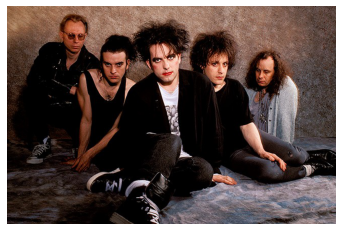

In [11]:
image_url = 'https://static.billboard.com/files/media/the-cure-1992-650-430-compressed.jpg' #@param {type:"string"}
response = requests.get(image_url, stream=True)

image = Image.open(response.raw).convert("RGB")
plt.imshow(image)
plt.axis("off")
plt.show()

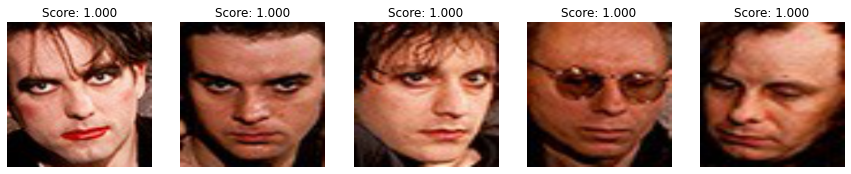

In [12]:
#@title Crop the images { run: "auto" }
margin = 15 #@param {type:"slider", min:0, max:158, step:5}

boxes, scores = detector.detect(image, landmarks=False)
faces = crop_faces(image, boxes, margin, 160)

# Plotting 
figure = plt.figure(figsize=(15, 5))

for idx, face in enumerate(faces):
    figure.add_subplot(1, len(faces), idx + 1)
    plt.title(f'Score: {scores[idx]:.3f}')
    plt.imshow(face)
    plt.axis("off")
    

Let's create a face identification pipeline using the LFW dataset to build our gallery.

## Get the Labeled Faces in the Wild  [dataset](http://vis-www.cs.umass.edu/lfw/)

In [ ]:
!wget http://vis-www.cs.umass.edu/lfw/lfw.tgz

In [14]:
!tar -zxf lfw.tgz

In face verification/identification, there should be no overlapping identities between the training set and testing set. This [repository](https://github.com/happynear/FaceDatasets) provides some overlapping lists between several training and testing datasets. In our case we need the overlapping list [CASIA-LFW](https://github.com/happynear/FaceDatasets/blob/master/CASIA/webface_lfw_overlap_detail.txt).

In [ ]:
!ls lfw

In [16]:
overlap_casia_lfw = ['William_Macy', 'Vanessa_Williams', 'Mary_Blige', 
                    'Laura_Elena_Harring', 'David_Kelley', 'Norm_Macdonald', 
                    'Hillary_Clinton', 'Wanda_de_la_Jesus', 'Michael_Jordan', 
                    'Nicole_Parker', 'Zhang_Ziyi', 'Prince_William', 'Liu_Ye', 
                    'Randy_Jackson', 'Jesse_James', 'John_Mabry', 'Richard_Cohen']

In [17]:
def remove_sub_folders(path_base: str, folders: str) -> int:
    """Removes all the sub folders inside the folder path_base.

    Args:
        path_base: the base path.
        folders: the folder to delete.

    Returns:
        the number of deleted folders.

    Raises:
        OSError: if is impossible to delete the folder.
    """
    num_deleted_folders = 0
    for folder in folders:
        path_folder = os.path.join(path_base, folder)
        try:
            shutil.rmtree(path_folder)
            num_deleted_folders += 1
        except OSError as e:
            print(f'Impossible to delete folder {path_folder}')
            raise
    return num_deleted_folders

In [18]:
remove_sub_folders('lfw', overlap_casia_lfw)

17

In [19]:
path_ds_lfw = "lfw"
dataset_lfw = torchvision.datasets.ImageFolder(path_ds_lfw)

identities = dataset_lfw.classes
num_identities = len(identities)

print(f'Images: {len(dataset_lfw)} - People: {num_identities}')

Images: 13189 - People: 5732


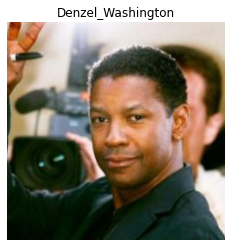

In [21]:
#@title Show Labeled Faces in the Wild Dataset { run: "auto", display-mode: "form" }
index_sample = 2859  #@param {type:"slider", min:0, max:13188, step:1}

image, label = dataset_lfw[index_sample]

plt.imshow(image)
plt.title(identities[label])
plt.axis("off")
plt.show()

## Build the Model Gallery

We need to crop all the images before create our embeddings gallery. Instead of cropping each single face from the image using the method shown above, we can use the [forward](https://github.com/timesler/facenet-pytorch/blob/dd0b0e4b5b124b599f75b87e570910e5d80c8848/models/mtcnn.py#L226) method of the MTCNN detector. However, it requires `PIL.Image`s as input, rather than `torch.tensors` as we have used so far. To create a batch of images, we can use
the [collate_pil](https://github.com/timesler/facenet-pytorch/blob/master/models/utils/training.py#L139) provided by the package.


In [22]:
from facenet_pytorch import training
num_workers = 2
size_batch = 16

loader_lfw = torch.utils.data.DataLoader(dataset_lfw, 
                                         batch_size=size_batch,
                                         pin_memory=True,
                                         num_workers=num_workers,
                                         collate_fn=training.collate_pil)

The attribute `samples` of a PyTorch `torchvision.datasets.ImageFolder` stores the path to the image and the class labels and they are the two information collated to create a mini-batch by the dataloader. However, we do not need the label, but we need the path of the image, to save its cropped vesion with the same path in a new folder. Hence, we overwrite the label with the path to the image in the lfw dataset.

In [23]:
print(dataset_lfw.samples)

[('lfw/AJ_Cook/AJ_Cook_0001.jpg', 0), ('lfw/AJ_Lamas/AJ_Lamas_0001.jpg', 1), ('lfw/Aaron_Eckhart/Aaron_Eckhart_0001.jpg', 2), ('lfw/Aaron_Guiel/Aaron_Guiel_0001.jpg', 3), ('lfw/Aaron_Patterson/Aaron_Patterson_0001.jpg', 4), ('lfw/Aaron_Peirsol/Aaron_Peirsol_0001.jpg', 5), ('lfw/Aaron_Peirsol/Aaron_Peirsol_0002.jpg', 5), ('lfw/Aaron_Peirsol/Aaron_Peirsol_0003.jpg', 5), ('lfw/Aaron_Peirsol/Aaron_Peirsol_0004.jpg', 5), ('lfw/Aaron_Pena/Aaron_Pena_0001.jpg', 6), ('lfw/Aaron_Sorkin/Aaron_Sorkin_0001.jpg', 7), ('lfw/Aaron_Sorkin/Aaron_Sorkin_0002.jpg', 7), ('lfw/Aaron_Tippin/Aaron_Tippin_0001.jpg', 8), ('lfw/Abba_Eban/Abba_Eban_0001.jpg', 9), ('lfw/Abbas_Kiarostami/Abbas_Kiarostami_0001.jpg', 10), ('lfw/Abdel_Aziz_Al-Hakim/Abdel_Aziz_Al-Hakim_0001.jpg', 11), ('lfw/Abdel_Madi_Shabneh/Abdel_Madi_Shabneh_0001.jpg', 12), ('lfw/Abdel_Nasser_Assidi/Abdel_Nasser_Assidi_0001.jpg', 13), ('lfw/Abdel_Nasser_Assidi/Abdel_Nasser_Assidi_0002.jpg', 13), ('lfw/Abdoulaye_Wade/Abdoulaye_Wade_0001.jpg', 14), (

In [24]:
dataset_lfw.samples = [(path, path) for path, _ in dataset_lfw.samples]
print(dataset_lfw.samples)

[('lfw/AJ_Cook/AJ_Cook_0001.jpg', 'lfw/AJ_Cook/AJ_Cook_0001.jpg'), ('lfw/AJ_Lamas/AJ_Lamas_0001.jpg', 'lfw/AJ_Lamas/AJ_Lamas_0001.jpg'), ('lfw/Aaron_Eckhart/Aaron_Eckhart_0001.jpg', 'lfw/Aaron_Eckhart/Aaron_Eckhart_0001.jpg'), ('lfw/Aaron_Guiel/Aaron_Guiel_0001.jpg', 'lfw/Aaron_Guiel/Aaron_Guiel_0001.jpg'), ('lfw/Aaron_Patterson/Aaron_Patterson_0001.jpg', 'lfw/Aaron_Patterson/Aaron_Patterson_0001.jpg'), ('lfw/Aaron_Peirsol/Aaron_Peirsol_0001.jpg', 'lfw/Aaron_Peirsol/Aaron_Peirsol_0001.jpg'), ('lfw/Aaron_Peirsol/Aaron_Peirsol_0002.jpg', 'lfw/Aaron_Peirsol/Aaron_Peirsol_0002.jpg'), ('lfw/Aaron_Peirsol/Aaron_Peirsol_0003.jpg', 'lfw/Aaron_Peirsol/Aaron_Peirsol_0003.jpg'), ('lfw/Aaron_Peirsol/Aaron_Peirsol_0004.jpg', 'lfw/Aaron_Peirsol/Aaron_Peirsol_0004.jpg'), ('lfw/Aaron_Pena/Aaron_Pena_0001.jpg', 'lfw/Aaron_Pena/Aaron_Pena_0001.jpg'), ('lfw/Aaron_Sorkin/Aaron_Sorkin_0001.jpg', 'lfw/Aaron_Sorkin/Aaron_Sorkin_0001.jpg'), ('lfw/Aaron_Sorkin/Aaron_Sorkin_0002.jpg', 'lfw/Aaron_Sorkin/Aaron_So

Now we can detect faces on the lfw dataset and save the cropped dataset.

In [25]:
detector = MTCNN(image_size=size_image,
                 margin=14,
                 device=device,
                 selection_method='center_weighted_size')

In [ ]:
path_ds_lfw_cropped = f'{path_ds_lfw }_cropped'

for i, (x, paths_batch) in tqdm(enumerate(loader_lfw), total=len(loader_lfw)):
    path_crop = [p.replace(path_ds_lfw, path_ds_lfw_cropped) for p in paths_batch]
    detector(x, save_path=path_crop)
        

  0%|          | 0/825 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/facenet_pytorch/models/utils/detect_face.py:183: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  batch_boxes, batch_points = np.array(batch_boxes), np.array(batch_points)
/usr/local/lib/python3.8/dist-packages/facenet_pytorch/models/mtcnn.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  boxes = np.array(boxes)
/usr/local/lib/python3.8/dist-packages/facenet_pytorch/models/mtcnn.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or nd

In [ ]:
dataset_lfw_cropped = torchvision.datasets.ImageFolder(path_ds_lfw_cropped)

In [ ]:
#@title Show the Cropped Dataset { run: "auto", display-mode: "form" }
index_sample = 11413  #@param {type:"slider", min:0, max:13188, step:1}

image, label = dataset_lfw_cropped[index_sample]

plt.imshow(image)
plt.title(identities[label])
plt.axis("off")
plt.show()

Now we can create the dataset and the data loader for the cropped images. As regard image normalization, we can use the `fixed_image_standardization` [method](https://github.com/timesler/facenet-pytorch/blob/dd0b0e4b5b124b599f75b87e570910e5d80c8848/models/mtcnn.py#L508), since the pre-trained models have been trained with the images normalized according to this [procedure](https://github.com/davidsandberg/facenet). Using the [`torch.utils.data.SequentialSampler`](https://pytorch.org/docs/stable/data.html) we will read the elements sequentially, always in the same order.

In [ ]:
from facenet_pytorch import fixed_image_standardization

transform_lfw = transforms.Compose([np.float32,
                                    transforms.ToTensor(),
                                    fixed_image_standardization])

dataset_lfw_cropped = torchvision.datasets.ImageFolder(path_ds_lfw_cropped, 
                                                       transform=transform_lfw)

sampler = torch.utils.data.SequentialSampler(dataset_lfw_cropped)
loader_lfw_cropped = torch.utils.data.DataLoader(dataset_lfw_cropped,
                                                 num_workers=num_workers,
                                                 batch_size=size_batch,
                                                 sampler=sampler)

Take the embedder pretrained on the Casia Web Face dataset.

In [ ]:
from facenet_pytorch import InceptionResnetV1

embedder = InceptionResnetV1(pretrained='casia-webface').eval()
embedder.to(device)
summary(embedder, input_size=(3, 160, 160))

Now everything is ready to create the gallery.

In [ ]:
gallery = []

with torch.no_grad():
    for image, labels in tqdm(loader_lfw_cropped):
        image = image.to(device)
        batch_embeddings = embedder(image)
        gallery.extend(batch_embeddings.to('cpu').numpy())     

gallery = np.asarray(gallery)
print(f'The gallery has: {len(gallery)} samples.')

Once we have created the gallery, in order to find the identity of a new subject we can classify its embedding using a k-Nearest Neighbor search. The most basic approach is the *brute force* which involves the computation of distances between all the embeddings in the gallery against the new one. Contrary, we will use a `K-D tree`, i.e. a tree-based data structure that helps overcome the computational cost of the brute force approach, whose implementation is available in `scikit-learn`.

In [ ]:
from sklearn.neighbors import NearestNeighbors

def nearest_neighbor(sources: np.ndarray, 
                     targets: np.ndarray,
                     num_neighbors: int,
                     algorithm: str = 'kd_tree') -> Tuple[np.ndarray, np.ndarray]:
    """Computes nearest neighbor search.

    Estimates for each sample in source the nearest neighbor in target using 
    the specified algorithm.
    
    Args:
        sources: the source samples.
        targets: the target samples.
        num_neighbors: the number of neighbors to find.
        algorithm: the algorithm to use kd_tree or brute force.

    Returns:
        The euclidean distance from each sample in source to the nearest neighbor in target.
        The indices of the nearest neighbor points on target for each sample in source.
    """    
    kd_tree = NearestNeighbors(n_neighbors=num_neighbors, 
                               algorithm=algorithm, 
                               metric='euclidean')
    kd_tree.fit(targets)
    distances, indices = kd_tree.kneighbors(sources)

    return distances, indices

Let's do a sanity check.

In [ ]:
num_neighbors = 3
idx_sanity = 7
nn_distances, nn_indices = nearest_neighbor(gallery[idx_sanity].reshape(1, -1),
                                            gallery,
                                            num_neighbors)

In [ ]:
def show_neighbors(query_image: PIL.Image.Image,                   
                   indices: np.ndarray,
                   distances: np.ndarray,
                   dataset: torchvision.datasets,
                   threshold: float,
                   class_query: str = None,
                   transform=None) -> None:
    """Shows the query image together with the found nearest neighbors.

    Args:
        query_image: the input image.        
        indices: the indices of nearest neighbors.
        distances: the distances of nearest neighbors.
        dataset: the dataset on which the gallery was built.
        threshold: the matching threshold
        class_query: the name of the class of the query image.
        transform: the transformation to apply to the image.        

    Returns:
    """
    distances = distances.squeeze()
    indices = indices.squeeze()
    num_images = len(indices) + 1

    figure = plt.figure(figsize=(15, 5))
    figure.add_subplot(1, num_images, 1)
    plt.imshow(query_image)
    class_query_title = class_query if class_query else '' 
    plt.title(f'Query \n {class_query_title} ', color='g')
    plt.axis("off")
    
    for idx, (idx_nn, dist_nn) in enumerate(zip(indices, distances)):        
        figure.add_subplot(1, num_images, idx + 2)
        image, label_matched = dataset[idx_nn]        
        
        if isinstance(label_matched, str):
            class_match = label_matched.split('/')[-1].split('.')[-2]
        else:
            class_match = dataset.classes[label_matched]

        if class_query is not None:
            color = 'g' if class_query == class_match else 'r'
        else:
            color = 'g' if dist_nn <= threshold else 'r'

        plt.title(f'{class_match} \n Distance: {dist_nn:.3f}', color=color)
        if transform:
            image = transform(image)
        plt.imshow(image)
        plt.axis("off")

In [ ]:
threshold = 0.85
show_neighbors(dataset_lfw[idx_sanity][0], nn_indices, nn_distances, dataset_lfw, 
               threshold)

Check one subject that is in the database.

In [ ]:
def get_image_from_url(image_url:str , mode:str ='RGB') -> PIL.Image.Image:
    """Downloads and opens the image from the url.

    Args:
        image_url: the url for the image.
        mode: a string which defines the type and depth of a pixel in the image.

    Returns:
        The image read.
    """
    response = requests.get(image_url, stream=True)    
    return Image.open(response.raw).convert(mode)

In [ ]:
def detect_and_embed(image: PIL.Image.Image, 
                     detector: nn.Module, 
                     embedder: nn.Module) -> Tuple[PIL.Image.Image,
                                                   np.ndarray]:
    """Detects the face from the image and then creates the embedding for it.

    Args:
        image: the input iamge.
        detector: the face detector.
        embedder: the embedder.

    Returns:
        The image of the cropped face.
        The embedding for the face.
    """
    detector.eval()
    embedder.eval()
    
    with torch.no_grad():
        image_face = detector(image)
        image_face_batch = image_face.unsqueeze(0)                
        embedding = embedder(image_face_batch.to(device))                
    
    embedding = embedding.to('cpu').numpy()    
    image_face = image_face.to('cpu')
    image_face = (image_face * (128. / 255.)) + (127. / 255.)
    image_face_pil = transforms.ToPILImage()(image_face)

    return image_face_pil, embedding

In [ ]:
#@title Show Matching {run: "auto", display-mode: "form" }
image_url = "https://upload.wikimedia.org/wikipedia/commons/d/d6/Paul_McCartney_in_October_2018.jpg" #@param ["https://www.occhionotizie.it/wp-content/uploads/2020/10/Bill_Gates_1-780x470.png", "https://s3-eu-west-1.amazonaws.com/static.screenweek.it/artist/1445.jpg", "https://upload.wikimedia.org/wikipedia/commons/d/d6/Paul_McCartney_in_October_2018.jpg", "https://www.rollingstone.it/wp-content/uploads/2019/12/GettyImages-82707180-e1575297588835.jpg", "https://biografieonline.it/img/bio/gallery/c/Claudio_Santamaria_1.jpg"]
image = get_image_from_url(image_url)

image_face, embedding = detect_and_embed(image, detector, embedder)

nn_distances, nn_indices = nearest_neighbor(embedding,
                                            gallery,
                                            num_neighbors)
show_neighbors(image_face, 
               nn_indices, 
               nn_distances, 
               dataset_lfw,
               threshold)

Let's add the novel subject to the gallery.

In [ ]:
urls = ['https://nientepopcorn.b-cdn.net/persone-img/big/claudio-santamaria-76339.jpg',
        'https://www.chi-e.net/wp-content/uploads/2020/01/claudio-santamaria.jpg']

name_subject = 'Claudio_Santamaria'
for idx, url in enumerate(urls):    
    image_face, embedding = detect_and_embed(get_image_from_url(url, mode='RGB'), 
                                             detector, 
                                             embedder)
    # Save the face    
    path_dir = os.path.join('new_subjects', name_subject)
    name_file = '{0}_{1:04}.jpg'.format(name_subject, idx)

    if not os.path.exists(path_dir):
        os.makedirs(path_dir)

    path_file = os.path.join(path_dir, name_file)
    image_face.save(path_file)    
    
    dataset_lfw.samples.append((path_file, path_file))
    gallery = np.concatenate((gallery, embedding))

In [ ]:
print(f'The gallery has: {len(gallery)} samples.')

# Now it's your turn to try: Image Retrieval


## CUB-200-2011 Dataset

The [**CUB-200-2011** dataset](http://www.vision.caltech.edu/visipedia/CUB-200-2011.html) has 200 species of birds with 11,788 images, where the first 100 species are used for training and the remaining 100 species are used for testing.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!ls "/content/drive/My Drive"

In [ ]:
!cp "/content/drive/My Drive/CUB_200_2011.tgz" "CUB_200_2011.tgz"

In [ ]:
!tar -xzf CUB_200_2011.tgz

Create two separate folders for the train and test data

In [ ]:
from shutil import copytree

def split_cub_dataset(path_source_dataset: str, path_dest_dataset: str) -> int:
    """Moves the folders into train and test folders.

    Args:
        path_source_dataset: the path to the source data set containing all the classes.
        path_dest_dataset: the path to the destination data set.

    Returns:
        the number of copied folder for the train and validation set.

    Raises:
        FileNotFoundError: if path_source_dataset has no sub folders.
    """
    num_copied_dirs = 0
    try:
        categories = sorted(os.listdir(os.path.join(path_source_dataset)))
    except FileNotFoundError:
        print(f'No directories found in {path_source_dataset}')
        raise

    if not os.path.exists(path_dest_dataset):
        os.mkdir(path_dest_dataset)

    categories_splits = [categories[:100], categories[100:200]]
    splits = ["train", "test"]
    for data_split, categories_split in zip(splits, categories_splits):
        for category in tqdm(categories_split, leave=False):
            copytree(os.path.join(path_source_dataset, category),
                     os.path.join(path_dest_dataset, data_split, category))
            num_copied_dirs += 1
    return num_copied_dirs

In [ ]:
def split_and_crop_cub_dataset(path_source_dataset: str,
                               path_dest_dataset: str,
                               ext_images: str,
                               path_file_images: str,
                               path_file_boxes: str,
                               margin: int,
                               size_crop: int) -> int:
    """Moves the folders into train and test folders cropping them according to the bounding boxes.

    Args:
        path_source_dataset: the path to the source data set containing all the classes.
        path_dest_dataset: the path to the destination data set.
        ext_images: image extension.
        path_file_images: path to the CUB dataset images.txt file.
        path_file_boxes:  path to the CUB annotations.txt file.
        margin: the margin for the cropped image.
        size_crop: the size of the crop, the image will be squared.

    Returns:
        the number of copied file for the train and validation set.

    Raises:
        FileNotFoundError: if path_source_dataset has no sub folders.
        ValueError: if path_source_dataset has no sub folders.
    """
    num_copied_images = 0
    try:
        categories = sorted(os.listdir(os.path.join(path_source_dataset)))
    except FileNotFoundError:
        print(f'No directories found in {path_source_dataset}')
        raise

    if not os.path.exists(path_dest_dataset):
        os.mkdir(path_dest_dataset)

    dict_image_id = {}
    with open(path_file_images, 'r') as file_images:
        for line in file_images.readlines():
            line_splitted = line.split(' ')
            id_image = int(line_splitted[0])
            name_file_image = line_splitted[1].split('/')[1].split('.')[0]

            dict_image_id[name_file_image] = id_image

    dict_id_boxes = {}
    with open(path_file_boxes, 'r') as file_boxes:
        for line in file_boxes.readlines():
            line_splitted = line.split(' ')
            id_image = int(line_splitted[0])
            box = [float(b) for b in line_splitted[1:]]

            try:
                x, y, w, h = float(box[0]), float(box[1]), float(box[2]), float(box[3])
            except ValueError:
                print(f'Error in converting float to string for the line {box}')
                raise

            dict_id_boxes[id_image] = [x, y, x + w, y + h]

    categories_splits = [categories[:100], categories[100:200]]
    splits = ["train", "test"]
    for data_split, categories_split in zip(splits, categories_splits):
        for category in tqdm(categories_split, leave=False):
            path_dest_category = os.path.join(path_dest_dataset, data_split, category)
            if not os.path.exists(path_dest_category):
                os.makedirs(path_dest_category)

            path_category = os.path.join(path_source_dataset, category)
            path_images = sorted([path for path in Path(path_category).rglob(f'*.{ext_images}')])

            for path_image in path_images:
                image = Image.open(path_image).convert('RGB')
                id_image = dict_image_id[path_image.stem]
                bounding_box = dict_id_boxes[id_image]
                bounding_box = np.asarray(bounding_box).reshape(1, 4)
                crop = crop_faces(image, bounding_box, margin, size_crop)[0]

                crop.save(os.path.join(path_dest_dataset, data_split, category, f'{path_image.stem}.{ext_images}'))
                num_copied_images += 1

    return num_copied_images


In [ ]:
path_splitted_cub = "CUB_200_2011_splitted"

In [ ]:
split_and_crop_cub_dataset('CUB_200_2011/images', 
                           path_splitted_cub,
                           'jpg',
                           'CUB_200_2011/images.txt',
                           'CUB_200_2011/bounding_boxes.txt',
                           margin=14,
                           size_crop=224)

## Triplet Dataset

We will use a siamese training in order to learn an embedding for our images, thus we need a dataset that can provide us batches where each sample contains 3 images: **anchor**, **positive**, **negative**. We want to ensure that the embedding of an image (anchor) of a specific category is closer to all other embeddings of images (positive) of the same category than it is to any embedding of image (negative) of any other categories as stated in [here](https://arxiv.org/pdf/1503.03832.pdf).


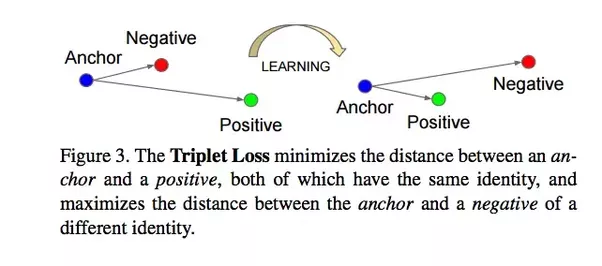

* Usually the triplets are computed using different mining strategies suche as semi-hard negative mining. Differently, we want to use a simpler strategy where the negatives are computed randomly.

* You have to fill the code for the `__getitem__(self, idx)` in order to return:
 * a [`tuple`](https://www.w3schools.com/python/python_tuples.asp) with the images for the anchor, the positive and the negative. 
 * a [`list`](https://www.w3schools.com/python/python_lists.asp) with the labels for the anchor, the positive and the negative.

* The `TripletDataset` inherits from the `torchvision.datasets.ImageFolder`:
 *   you can get all the paths to the images in the dataset accessing the attribute `self.samples`.
 *   similarly you can get all the labels of the images in the dataset accessing the attribute `self.targets`.
 * remember that an anchor and a positive have the same label.
 * given an anchor sample, the method [`numpy.nonzero`](https://numpy.org/doc/stable/reference/generated/numpy.nonzero.html#numpy.nonzero) can be used to get the indices of samples having the same label. 
 * the [set](https://www.w3schools.com/python/python_sets.asp) data structure can be useful to carry out subtractions between data structures.
 * the function `random.choice` can be used to randomly get samples from a `list` of numbers.
 



In [ ]:
import random
from pathlib import Path
from torch.utils.data import Dataset

class TripletDataset(torchvision.datasets.ImageFolder):

    def __init__(self, path, transforms=None):
        super(TripletDataset, self).__init__(root=path)        
        self.transforms = transforms
        self.targets_np = np.array(self.targets)

    def __getitem__(self, idx):
        # ==================================================================== #
        #                         YOUR CODE STARTS HERE                        #
        # ==================================================================== # 
        raise NotImplementedError("Fill this part with your code.")
        # ==================================================================== #
        #                         YOUR CODE ENDS HERE                          #
        # ==================================================================== #  
        if self.transforms is not None:
            anchor = self.transforms(anchor)
            positive = self.transforms(positive)
            negative = self.transforms(negative)
        return (anchor, positive, negative), [label_anchor, label_positive, label_negative]

In [ ]:
normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

transforms_bird = {'train': transforms.Compose([transforms.RandomHorizontalFlip(),
                                                transforms.ToTensor(),
                                                normalize]),
                   'val': transforms.Compose([transforms.ToTensor(),
                                              normalize])}

dataset_bird_train = TripletDataset(path=os.path.join(path_splitted_cub, 'train'),
                                    transforms=transforms_bird['train'])

dataset_bird_val = TripletDataset(path=os.path.join(path_splitted_cub, 'test'),
                                  transforms=transforms_bird['val'])

species = dataset_bird_train.classes
num_species = len(species)

print(f'Images: {len(dataset_bird_train)} - Species: {num_species}')

In [ ]:
#@title Show Triplet Dataset { run: "auto", display-mode: "form" }
index_sample = 21  #@param {type:"slider", min:0, max:5863, step:1}

class NormalizeInverse(torchvision.transforms.Normalize):
    def __init__(self, mean: List[float], std: List[float]) -> None:
        """Reconstructs the images in the input domain by inverting 
        the normalization transformation.

        Args:
            mean: the mean used to normalize the images.
            std: the standard deviation used to normalize the images.
        """
        mean = torch.as_tensor(mean)
        std = torch.as_tensor(std)
        std_inv = 1 / (std + 1e-7)
        mean_inv = -mean * std_inv
        super().__init__(mean=mean_inv, std=std_inv)

    def __call__(self, tensor):
        return super().__call__(tensor.clone())


unormalize = NormalizeInverse([0.485, 0.456, 0.406], 
                              [0.229, 0.224, 0.225])

triplet, labels = dataset_bird_train[index_sample]

anchor = transforms.ToPILImage()(unormalize(triplet[0]))
positive = transforms.ToPILImage()(unormalize(triplet[1]))
negative = transforms.ToPILImage()(unormalize(triplet[2]))


figure = plt.figure(figsize=(15, 5))
figure.add_subplot(1, 3, 1)
class_anch = species[labels[0]].split('.')[-1]
plt.title(f'Anchor \n {class_anch} ', color='b')
plt.imshow(anchor)
plt.axis("off")

figure.add_subplot(1, 3, 2)
class_pos = species[labels[1]].split('.')[-1]
plt.title(f'Positive \n {class_pos} ', color='g')
plt.imshow(positive)
plt.axis("off")

figure.add_subplot(1, 3, 3)
class_neg = species[labels[2]].split('.')[-1]
plt.title(f'Negative \n {class_neg} ', color='r')
plt.imshow(negative)
plt.axis("off")

plt.tight_layout()
plt.show()

Use the following data loaders.

In [ ]:
num_workers = 2
size_batch = 128

loader_cub_train = torch.utils.data.DataLoader(dataset_bird_train,
                                               batch_size=size_batch,
                                               shuffle=True,
                                               pin_memory=True,
                                               num_workers=num_workers)

loader_cub_val = torch.utils.data.DataLoader(dataset_bird_val,
                                             batch_size=size_batch,
                                             pin_memory=True,
                                             num_workers=num_workers)

print(f'Batches train: {len(loader_cub_train)} - val: {len(loader_cub_val)}')

## Create your Image Embedding Network

Fill the code of the `Embedder` class:

1. Use the attribute `self.feat_ext` to store a pretrained [ResNet18](https://pytorch.org/docs/stable/torchvision/models.html).
2. Use the attribute `self.embedding` to store  a [fully connected layer](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) to get the final embedding of size 512.
3. Normalize the final embedding using the `torch.nn.functional.normalize` function described [here](https://pytorch.org/docs/stable/nn.functional.html).

Fill the code of the `forward` method to compute the embedding for the anchor, the positive and the negative. Be careful at test time method should work only on the anchor...

In [ ]:
def set_requires_grad_for_layer(layer: torch.nn.Module, train: bool) -> None:
    """Sets the attribute requires_grad to True or False for each parameter.
        
        Args:
            layer: the layer to freeze.
            train: if true train the layer.
    """
    for p in layer.parameters():
        p.requires_grad = train

class Embedder(nn.Module):
    """    
    
    Neural network to compute image embedding.        
    
        size_embedding: the size for the embedding.
        normalize_embedding: if True normalize the embedding using the L2 norm.
        pretrained_feature_extactor: if True use a pretrained feature extractor.
        train_feature_extactor: if True train the feature extractor.    
    
    """ 
    def __init__(self, 
                 size_embedding: int,
                 normalize_embedding: bool,
                 pretrained_feature_extactor: bool,
                 train_feature_extactor: bool) -> None:        
        super().__init__()
        # ==================================================================== #
        #                         YOUR CODE STARTS HERE                        #
        # ==================================================================== #        
        raise NotImplementedError("Fill this part with your code.")
        # ==================================================================== #
        #                         YOUR CODE ENDS HERE                          #
        # ==================================================================== # 

    def forward(self, anchor, positive=None, negative=None):
        # ==================================================================== #
        #                         YOUR CODE STARTS HERE                        #
        # ==================================================================== #        
        raise NotImplementedError("Fill this part with your code.")
        # ==================================================================== #
        #                         YOUR CODE ENDS HERE                          #
        # ==================================================================== # 

In [ ]:
bird_embedder = Embedder(size_embedding=512,
                         normalize_embedding=True,
                         pretrained_feature_extactor=True,
                         train_feature_extactor=True)

summary(bird_embedder, input_size=(3, 224, 224), device='cpu')

## Train the Model

In [ ]:
# Train one epoch
def train(writer: utils.tensorboard.writer.SummaryWriter,
          model: nn.Module,
          train_loader: utils.data.DataLoader,
          device: torch.device,          
          optimizer: torch.optim,
          criterion: Callable[[torch.Tensor, torch.Tensor], float],
          log_interval: int,
          epoch: int) -> Tuple[float]:
    """Trains a neural network for one epoch.

    Args:
        model: the model to train.
        train_loader: the data loader containing the training data.
        device: the device to use to train the model.        
        optimizer: the optimizer to use to train the model.
        criterion: the loss to optimize.
        log_interval: the log interval.
        epoch: the number of the current epoch.

    Returns:
        the loss value on the training data.        
    """    
    samples_train = 0
    loss_train = 0
    size_ds_train = len(train_loader.dataset)
    num_batches = len(train_loader)

    model.train()
    for idx_batch, (triplet, labels) in enumerate(train_loader):
        anchors = triplet[0].to(device)
        positives = triplet[1].to(device)
        negatives = triplet[2].to(device)        

        optimizer.zero_grad()
        embedding_anc, embedding_pos, embedding_neg = model(anchors,
                                                            positives, 
                                                            negatives)

        loss = criterion(embedding_anc, embedding_pos, embedding_neg)        
        loss_train += loss.item() * len(anchors)
        samples_train += len(anchors)

        loss.backward()
        optimizer.step()        

        if log_interval > 0:
            if idx_batch % log_interval == 0:
                running_loss = loss_train / samples_train
                global_step = idx_batch + (epoch * num_batches) 
                writer.add_scalar('Metrics/Loss_Train_IT', running_loss, global_step)                
                
    loss_train /= samples_train    
    return loss_train

# Validate one epoch
def validate(model: nn.Module,
             data_loader: utils.data.DataLoader,
             device: torch.device,
             criterion: Callable[[torch.Tensor, torch.Tensor], float]) -> Tuple[float, float]:
    """Evaluates the model.

    Args:
        model: the model to evalaute.
        data_loader: the data loader containing the validation or test data.
        device: the device to use to evaluate the model.
        criterion: the loss function.

    Returns:
        the loss value on the validation data.        
    """    
    samples_val = 0
    loss_val = 0.
    
    model = model.eval()
    with torch.no_grad():
        for idx_batch, (triplet, labels) in enumerate(data_loader):
            anchors = triplet[0].to(device)
            positives = triplet[1].to(device)
            negatives = triplet[2].to(device)            
            
            embedding_anc, embedding_pos, embedding_neg = model(anchors,
                                                                positives, 
                                                                negatives)

            loss = criterion(embedding_anc, embedding_pos, embedding_neg)
            loss_val += loss.item() * len(triplet)
            samples_val += len(triplet)            

    loss_val /= samples_val    
    return loss_val

In [ ]:
def training_loop(writer: utils.tensorboard.writer.SummaryWriter,
                  num_epochs: int,
                  optimizer: torch.optim, 
                  lr_scheduler: torch.optim.lr_scheduler,
                  log_interval: int, 
                  model: nn.Module,
                  criterion: nn.Module,
                  loader_train: utils.data.DataLoader, 
                  loader_val: utils.data.DataLoader, 
                  verbose: bool=True) -> Dict:
    """Executes the training loop.
    
        Args:
            writer: the summary writer for tensorboard.
            num_epochs: the number of epochs.
            optimizer: the optimizer to use.
            lr_scheduler: the scheduler for the learning rate.
            log_interval: intervall to print on tensorboard.
            model: the mode to train.
            criterion: the loss to minimize.
            loader_train: the data loader containing the training data.
            loader_val: the data loader containing the validation data.
            verbose: if true print the value of loss.

        Returns:  
            A dictionary with the statistics computed during the train:
            the values for the train loss for each epoch.
            the values for the validation loss for each epoch.            
            the time of execution in seconds for the entire loop.
    """    
    loop_start = timer()

    losses_values_train = []
    losses_values_val = []

    for epoch in range(1, num_epochs + 1):
        time_start = timer()
        loss_train = train(writer, model, loader_train, device, optimizer, criterion, log_interval, epoch)
        loss_val = validate(model, loader_val, device, criterion)
        time_end = timer()

        losses_values_train.append(loss_train)
        losses_values_val.append(loss_val)

        lr = optimizer.param_groups[0]['lr']
        
        if verbose:            
            print(f'Epoch: {epoch} '
                  f' Lr: {lr:.8f} '
                  f' Loss: Train = [{loss_train:.4f}] - Val = [{loss_val:.4f}] '                  
                  f' Time one epoch (s): {(time_end - time_start):.4f} ')
        
        # Plot to tensorboard        
        writer.add_scalar('Hyperparameters/Learning Rate', lr, epoch)
        writer.add_scalars('Metrics/Losses', {"Train": loss_train, "Val": loss_val}, epoch)        
        writer.flush()
        
        # Increases the internal counter
        if lr_scheduler:            
            lr_scheduler.step()            
    
    loop_end = timer()
    time_loop = loop_end - loop_start
    if verbose:
        print(f'Time for {num_epochs} epochs (s): {(time_loop):.3f}') 
        
    return {'loss_values_train': losses_values_train,
            'loss_values_val': losses_values_val,
            'time': time_loop}

We have enough samples in the dataset to fine-tune the network. We are going to use two different learning rates for the `feature_ext` and the `embedding`.

In [ ]:
def execute(name_train: str, 
            model: nn.Module,
            criterion: nn.Module,
            starting_lr: float, 
            num_epochs: int, 
            data_loader_train: torch.utils.data.DataLoader,
            data_loader_val: torch.utils.data.DataLoader) -> None:
    """Executes the training loop.

    Args:
        name_train: the name for the log subfolder.
        model: the model to train.
        criterion: the loss to minimize.
        starting_lr: the staring learning rate.
        num_epochs: the number of epochs.
        data_loader_train: the data loader with training data.
        data_loader_val: the data loader with validation data.
    """
    # Visualization 
    log_interval = 20
    log_dir = os.path.join('logs', name_train)
    writer = torch.utils.tensorboard.writer.SummaryWriter(log_dir)
    
    # Optimization
    optimizer = optim.Adam(model.parameters(), lr=starting_lr)

    optim.SGD([{'params': model.feature_ext.parameters()},
               {'params': model.embedding.parameters(), 'lr': 10 * starting_lr}],
              lr=starting_lr, momentum=0.9)
 
    # Learning Rate schedule 
    scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

    statistics = training_loop(writer, 
                               num_epochs, 
                               optimizer, 
                               scheduler, 
                               log_interval, 
                               model, 
                               criterion, 
                               data_loader_train, 
                               data_loader_val)
    writer.close()

    # Save the model    
    if not os.path.exists('checkpoints'):
        os.makedirs('checkpoints')
    
    path_checkpoint = os.path.join('checkpoints',
                                   f'{name_train}_{num_epochs}_epochs.bin')
    torch.save(model.state_dict(), path_checkpoint)

    best_epoch = np.argmin(statistics['loss_values_val']) + 1
    best_loss_val = statistics['loss_values_val'][best_epoch - 1]

    print(f'Lowest val loss: {best_loss_val:.2f} at epoch: {best_epoch}.')

As loss, you can use the `TripletMarginLoss` implemented in PyTorch
[`torch.nn.TripletMarginLoss`](https://pytorch.org/docs/stable/generated/torch.nn.TripletMarginLoss.html#torch.nn.TripletMarginLoss).

In [ ]:
del bird_embedder
torch.cuda.empty_cache()

It should take 5 minutes per epoch.

In [ ]:
bird_embedder = Embedder(size_embedding=512,
                         normalize_embedding=True,
                         pretrained_feature_extactor=True,
                         train_feature_extactor=True)
bird_embedder.to(device)
name_train = "embedder_triplet"
lr = 0.00001
num_epochs = 4
margin = 0.30
criterion = torch.nn.TripletMarginLoss(margin=margin)

In [ ]:
execute(name_train, 
        bird_embedder, 
        criterion, 
        lr, 
        num_epochs,
        loader_cub_train,
        loader_cub_val)

## Test the model

In [ ]:
def build_gallery(embedder: nn.Module, 
                  loader: torch.utils.data.DataLoader, 
                  device: torch.device) -> np.ndarray:
    """Builds gallery using the images in the dataloader

    Args:
        embedder: the model to use to get the embedding.
        loader: the dataloader containing the dataset on which build the gallery.
        device: the device to use for the model.

    Returns:
        The gallery, i.e. an array with all the embeddings for the images 
        in the dataset.
    """
    gallery = []
    with torch.no_grad():
        for image, _ in tqdm(loader):
            image = image.to(device)
            batch_embeddings = embedder(image)        
            gallery.extend(batch_embeddings.to('cpu').numpy())     

    return np.asarray(gallery)

In [ ]:
dataset_bird_test = torchvision.datasets.ImageFolder(root=os.path.join(path_splitted_cub, 'test'),
                                                     transform=transforms_bird['val'])

sampler = torch.utils.data.SequentialSampler(dataset_bird_test)
loader_cub_test = torch.utils.data.DataLoader(dataset_bird_test,
                                              batch_size=1,
                                              pin_memory=True,
                                              shuffle=False,
                                              num_workers=num_workers,
                                              sampler=sampler)


In [ ]:
bird_embedder = bird_embedder.eval()
gallery_cub = build_gallery(bird_embedder, loader_cub_test, device)
print(f'The CUB gallery has: {len(gallery_cub)} samples')

In [ ]:
#@title Show Matching {run: "auto", display-mode: "form" }
index = 766 #@param {type:"slider", min:0, max:5924, step:1}
num_neighbors = 3 #@param {type:"integer"}

image_bird, label_query = dataset_bird_test[index]
image_bird = image_bird.unsqueeze(0).to(device)
with torch.no_grad():
    embedding_bird = bird_embedder(anchor=image_bird)
    embedding_bird = embedding_bird.to('cpu').numpy()

nn_distances, nn_indices = nearest_neighbor(embedding_bird,
                                            gallery_cub,
                                            num_neighbors)

image_bird = image_bird[0].to('cpu')
transform_show = transforms.Compose([unormalize,
                                     transforms.ToPILImage()])
image_bird = transform_show(image_bird)
show_neighbors(image_bird, 
               nn_indices, 
               nn_distances, 
               dataset_bird_test,
               0.0,
               dataset_bird_test.classes[label_query],
               transform_show)

## Compute the Recall@R

To asses the performance of retrieval method, we can compute the Recall@R which is the standard metric for image retrieving evaluation. It is defined as the percentage of the testing examples whose R nearest neighbors contain at least one example of the same class (Recall@R).

In [ ]:
from sklearn.neighbors import KDTree

def get_recalls(model: nn.Module,
                dataset: torchvision.datasets.ImageFolder, 
                gallery: np.ndarray, 
                kk: List[int]) -> Dict[int, float]:
    """Computes the recall using different nearest neighbors searches.
                
    Args:
        model: the model to use to compute the embedding.
        dataset: the dataset to use to compute the recall.
        gallery: the gallery containing all the embeddings for the dataset.
        kk: the number of nearest neighbors to use for each recall.

    Returns:
        The computed recalls with different nearest neighbors searches.
    """
    model.eval().cuda()
    max_nn = max(kk)    
    recalls = {idx: 0. for idx in kk}
    targets = np.asarray(dataset.targets)
    tree = KDTree(gallery)              

    for image_query, label_query in tqdm(dataset):                 
        image_query = image_query.unsqueeze(0).cuda()        

        with torch.no_grad():
            embedding = model(anchor=image_query)
            embedding = embedding.to('cpu').numpy()
                        
            _, indices_matched = tree.query(embedding, k=max_nn + 1) 
            indices_matched = indices_matched[0]

            for k in kk:
                indices_matched_temp = indices_matched[1:k + 1]                
                classes_matched = targets[indices_matched_temp]                
                recalls[k] += np.count_nonzero(classes_matched == label_query) > 0                
    
    for key, value in recalls.items():
        recalls[key] = value / (1.0 * len(dataset))

    return recalls

In [ ]:
def print_recalls(recalls: Dict[int, float]) -> None:
    """Prints the recalls at different k.

    Args:
        recalls: The computed recalls with different nearest neighbors searches.

    Returns: None
    """
    for key, value in recalls.items():
        print(f'Recall@{key} : {100. * value:.2f}%')    

In [ ]:
recalls_with_triplet = get_recalls(bird_embedder, dataset_bird_test, gallery_cub, [1, 2, 4])

In [ ]:
print('============ Recall with Triplet ============')
print_recalls(recalls_with_triplet)
print('============ Recall with Triplet ============')

# Try This at Home

* Implement the Angular Loss filling the following cells.
* Try the image recognition pipeline with your photos and those of your friends.
* Train using more epochs on CUB200.
* Try different margin values for the Triplet loss on CUB200.
* Use the [CARS196](https://cvgl.stanford.edu/projects/lifted_struct/) 
dataset without bounding boxes. 
As regard image settings: 
 * **training**: random crops and horizontal flipping. 
 * **test**: center crop.







## Angular Loss

You have to fill the code of the `AngularLoss` class in order to implement the [angular loss](https://arxiv.org/pdf/1708.01682.pdf). 

The main idea behind the angular loss is to encode the third-order relation inside a triplet in terms of the angle at the negative point. By constraining  the upper bound of the angle the angular can avoid to use a fixed margin $m$, which is often undesirable because different classes have different intra-class variations.
We want to use a slightly different version of the original angular loss.

Givena a triplet of embeddings $\mathcal{T} = (\mathcal{x}_a, \mathcal{x}_p, \mathcal{x}_n)$ the angular loss can be formalized as:

\begin{align}
  f_{a,p,n} = 4\tan^{2}\alpha(\mathbf{x}_a + \mathbf{x}_p)^T \mathbf{x}_n - 2(1 + \tan^{2}\alpha) \mathbf{x}_a^T \mathbf{x}_p. \nonumber
\end{align}

\begin{align}
  \mathcal{L}_{angular}(\mathbf{B}) = \frac{1}{N} \sum_{\mathbf{x}_a \in \mathbf{B}}\bigg\{\log\bigg[1
                 + \exp\big (f_{a,p,n}\big)\bigg] \bigg\}
\end{align}


*   The output of the `forward` should be the average loss calculated on all the elements in the batch.
*   To multiply tensors you can use the PyTorch API [`torch.matmul`](https://pytorch.org/docs/stable/generated/torch.matmul.html).



In [ ]:
class AngularLoss(nn.Module):
    """
    
    Class implementing Angular loss.
    Wang, Jian. "Deep Metric Learning with Angular Loss," ICCV, 2017    
    
    alpha: the bound for the angle in degrees.

    """
    def __init__(self, alpha):
        super(AngularLoss, self).__init__()
        self.alpha = alpha

    def forward(self, anchors, positives, negatives):        
        # ==================================================================== #
        #                         YOUR CODE STARTS HERE                        #
        # ==================================================================== #        
        raise NotImplementedError("Fill this part with your code.")
        # ==================================================================== #
        #                         YOUR CODE ENDS HERE                          #
        # ==================================================================== #
        return loss

Train the new model with the new loss.

In [ ]:
bird_embedder_angular = Embedder(size_embedding=512,
                                 normalize_embedding=True,
                                 pretrained_feature_extactor=True,
                                 train_feature_extactor=True)
bird_embedder_angular.to(device)
name_train = "embedder_angular"
lr = 0.00001
num_epochs = 8
criterion = AngularLoss(45)

execute(name_train, 
        bird_embedder_angular, 
        criterion, 
        lr, 
        num_epochs,
        loader_cub_train,
        loader_cub_val)

We have to rebuild our gallery with the new embeddings.

In [ ]:
bird_embedder_angular.eval()
gallery_cub = build_gallery(bird_embedder_angular, loader_cub_test, device)

print(f'The CUB gallery has: {len(gallery_cub)} samples')

In [ ]:
recalls_with_angular = get_recalls(bird_embedder_angular, 
                                   dataset_bird_test, 
                                   gallery_cub, [1, 2, 4])

Check the recall with the new loss.

In [ ]:
print('============ Recall with Angular ============')
print_recalls(recalls_with_angular)
print('=============================================')